# NLP + Binary Classification with Stock Market Tweets

This <a href="https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction" target="new">Kaggle</a> dataset contains over 64,000 tweets for the top 25 most watched stock tickers on Yahoo Finance for the fiscal year of 2022.

Aim:

• Use NLP to classify and predict whether a tweet is regarding MAMAA (one of the top 5 tech stocks) or not, to measure social media engagement. <a href="https://www.forbes.com/advisor/investing/faang-stocks-mamaa/" target="new">MAMAA</a> consists of: Meta, Apple, Microsoft, Amazon, Alphabet. MAMAA was initially known as FAANG.

• Assess if Twitter is an effective platform for an a MAMAA company for audience interaction.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.lda_model
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Additional imports to "translate" emoji
from transformers import AutoTokenizer
import emoji

In [3]:
df = pd.read_csv("data/stock_tweets.csv")
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [4]:
df["Stock Name"].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [6]:
df["Stock Name"].value_counts()

Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

In [7]:
df.drop_duplicates()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


Preprocessing

In [8]:
df = df.replace({"TSLA": "Tesla", "TSM": "Taiwan Semiconductor", "AAPL": "Apple", "AMZN": "Amazon", "PG": "Procter & Gamble", "MSFT": "Microsoft", 
"NFLX": "Netflix", "GOOGL": "Alphabet", "GOOG": "Alphabet", "Google": "Alphabet", "PYPL": "Paypal", "DIS": "Disney", "BA": "Boeing", "COST": "Costco", "INTC": "Intel", "KO": "Coca-Cola",
"CRM": "Salesforce", "XPEV": "Xpeng", "ENPH": "Enphase", "ZS": "Zscaler", "VZ": "Verizon", "BX": "Blackstone", "NOC": "Northrop",
"NVDA": "NVIDIA"}, regex=True)
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,Tesla,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,Tesla,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,Tesla,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",Tesla,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,Xpeng,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",Xpeng,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,Xpeng,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",Xpeng,XPeng Inc.


In [9]:
def emojidescription(text):
  return emoji.replace_emoji(text, replace=lambda chars, data_dict: " ".join(data_dict["en"].split("_")).strip(":"))

In [10]:
df["EmojiToken"] = df["Tweet"].apply(emojidescription)
df

,Date,Tweet,Stock Name,Company Name,EmojiToken
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,Tesla,"Tesla, Inc.",Mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,Tesla,"Tesla, Inc.",3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,Tesla,"Tesla, Inc.",@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",Tesla,"Tesla, Inc.","@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,Xpeng,XPeng Inc.,Some of the fastest growing tech stocks on the...
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",Xpeng,XPeng Inc.,"With earnings on the horizon, here is a quick ..."
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,Xpeng,XPeng Inc.,Our record delivery results are a testimony of...
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",Xpeng,XPeng Inc.,"We delivered 10,412 Smart EVs in Sep 2021, rea..."


Confirm if the emojidescription function worked:

In [11]:
print(df["Tweet"].iloc[54619])

Good morning TRADERS 💥👍

#stickynote below 

$Apple $TWTR $BBIG $AMD $FB https://t.co/OEavuCYFTf


In [12]:
print(df["EmojiToken"].iloc[54619])

Good morning TRADERS collisionthumbs up

#stickynote below 

$Apple $TWTR $BBIG $AMD $FB https://t.co/OEavuCYFTf


In [13]:
#Added these stop words after the initial normalization step
addstopwords = ["@", "amp"]

stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(addstopwords)
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
def clean(tweets):
    retext = re.sub("((www.[^s]+)|(https?://[^s]+))", " ", tweets)

    tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)
    tokens = tokenizer.tokenize(retext)

    stoptokens = [token.lower() for token in tokens if ((token.isalpha()) & (token.lower() not in stopwords))]

    stemmer = SnowballStemmer(language="english")
    stems = [stemmer.stem(word) for word in stoptokens]
    return stems

A prior run of lemmatization returned words that greatly reduced topics for NMF, as tokens appeared not very connected which each other after that process.

In [15]:
df["TweetNorm"] = df["EmojiToken"].apply(clean)
df.sample(10)

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm
12399,2022-05-10 01:51:22+00:00,Remind me to revisit this tweet in 2032 $Tesla...,Tesla,"Tesla, Inc.",Remind me to revisit this tweet in 2032 $Tesla...,"[remind, revisit, tweet, tesla]"
42085,2022-07-28 12:12:20+00:00,You want revenue growth. Buy Amazon\n\nYou wan...,Procter & Gamble,Procter & Gamble Company,You want revenue growth. Buy Amazon\n\nYou wan...,"[want, revenu, growth, buy, amazon, want, bran..."
74836,2022-02-15 18:20:57+00:00,$Disney theme parks to reportedly make face ma...,Disney,The Walt Disney Company,$Disney theme parks to reportedly make face ma...,"[disney, theme, park, report, make, face, mask..."
37137,2021-10-02 19:51:46+00:00,Here’s a long-time growth PM’s perspective on ...,Tesla,"Tesla, Inc.",Here’s a long-time growth PM’s perspective on ...,"[growth, pm, perspect, tesla, deliveri, came, ..."
53856,2022-09-01 00:37:36+00:00,🚨 $AMD was told to stop shipping AI chips to C...,AMD,"Advanced Micro Devices, Inc.",police car light $AMD was told to stop shippin...,"[polic, car, light, amd, told, stop, ship, ai,..."
10993,2022-05-21 02:59:26+00:00,@ps_pride @RobotPiratNinja @RandomKiwi_ @Mjarc...,Tesla,"Tesla, Inc.",@ps_pride @RobotPiratNinja @RandomKiwi_ @Mjarc...,[underground]
66966,2022-04-20 01:50:59+00:00,Taiwan Semiconductor FTX NAL https://t.co/0xVi...,Taiwan Semiconductor,Taiwan Semiconductor Manufacturing Company Lim...,Taiwan Semiconductor FTX NAL https://t.co/0xVi...,"[taiwan, semiconductor, ftx, nal]"
35818,2021-10-16 13:22:00+00:00,These minicharts shows US luxury vehicle sales...,Tesla,"Tesla, Inc.",These minicharts shows US luxury vehicle sales...,"[minichart, show, us, luxuri, vehicl, sale, br..."
72915,2021-10-28 19:48:11+00:00,@Choculusmilk @Taiwan Semiconductor_Leffen Cra...,Taiwan Semiconductor,Taiwan Semiconductor Manufacturing Company Lim...,@Choculusmilk @Taiwan Semiconductor_Leffen Cra...,"[crazi, thing, black, white, lol]"
22164,2022-02-01 12:07:26+00:00,$Tesla barely red premarket on nonsense “recal...,Tesla,"Tesla, Inc.",$Tesla barely red premarket on nonsense “recal...,"[tesla, bare, red, premarket, nonsens, recal, ..."


In [16]:
#Any length smaller than this makes the later pyLDAvis visualization not work
df = df[df["TweetNorm"].map(len) > 3]
df

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,Tesla,"Tesla, Inc.",Mainstream media has done an amazing job at br...,"[mainstream, media, done, amaz, job, brainwash..."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...,"[tesla, deliveri, estim, around, analyst, tsla]"
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,Tesla,"Tesla, Inc.",3/ Even if I include 63.0M unvested RSUs as of...,"[even, includ, unvest, rsus, addit, equiti, ne..."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,Tesla,"Tesla, Inc.",@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,"[hahaha, still, tri, stop, tesla, fsd, bro, ge..."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",Tesla,"Tesla, Inc.","@RealDanODowd @Tesla Stop trying to kill kids,...","[stop, tri, kill, kid, sad, derang, old, man]"
...,...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,Xpeng,XPeng Inc.,Some of the fastest growing tech stocks on the...,"[fastest, grow, tech, stock, market, mix, upst..."
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",Xpeng,XPeng Inc.,"With earnings on the horizon, here is a quick ...","[earn, horizon, quick, snapshot, largest, incr..."
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,Xpeng,XPeng Inc.,Our record delivery results are a testimony of...,"[record, deliveri, result, testimoni, unwav, p..."
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",Xpeng,XPeng Inc.,"We delivered 10,412 Smart EVs in Sep 2021, rea...","[deliv, smart, ev, sep, reach, mileston, unit,..."


Corpus:

In [17]:
output = df["TweetNorm"].apply(" ".join)
output

0        mainstream media done amaz job brainwash peopl...
1                 tesla deliveri estim around analyst tsla
2        even includ unvest rsus addit equiti need rsus...
3        hahaha still tri stop tesla fsd bro get shit t...
4                     stop tri kill kid sad derang old man
                               ...                        
80788    fastest grow tech stock market mix upst xpeng ...
80789    earn horizon quick snapshot largest increas co...
80790    record deliveri result testimoni unwav pursuit...
80791    deliv smart ev sep reach mileston unit month d...
80792    xpeng deliv outstand perform extrem condit ceo...
Name: TweetNorm, Length: 75754, dtype: object

In [18]:
#Remove comment to export CSV
#output.to_csv("data/output.csv")

In [19]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(output)
X_train

<75754x26946 sparse matrix of type '<class 'numpy.float64'>'
	with 1111542 stored elements in Compressed Sparse Row format>

In [20]:
len(vectorizer.get_feature_names_out())

26946

In [21]:
topicmodel = NMF(n_components=5)
topicmodel.fit(X_train)

NMF(n_components=5)

In [22]:
H = topicmodel.transform(X_train)
W = topicmodel.components_

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (5, 26946)
Shape of H is (75754, 5)
Shape of X_train is (75754, 26946)


In [23]:
for index, topic in enumerate(W):
    print(f"The Top 10 Words for Topic #{index}")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print("\n")

The Top 10 Words for Topic #0
['think', 'ev', 'model', 'nio', 'one', 'tsla', 'sold', 'musk', 'get', 'price', 'new', 'time', 'like', 'car', 'market', 'go', 'year', 'stock', 'day', 'today', 'buy', 'sell', 'elon', 'share', 'tesla']


The Top 10 Words for Topic #1
['week', 'boe', 'brk', 'salesforc', 'facebook', 'snow', 'snap', 'roku', 'return', 'shop', 'btc', 'sq', 'paypal', 'tesla', 'meta', 'qqq', 'amazon', 'spi', 'amd', 'netflix', 'fb', 'nvidia', 'alphabet', 'microsoft', 'appl']


The Top 10 Words for Topic #2
['match', 'guy', 'semiconductorwin', 'valor', 'like', 'time', 'back', 'player', 'get', 'one', 'thank', 'ggs', 'good', 'final', 'fan', 'go', 'smile', 'win', 'game', 'play', 'team', 'vs', 'face', 'taiwan', 'semiconductor']


The Top 10 Words for Topic #3
['drop', 'watchlist', 'day', 'break', 'next', 'fail', 'test', 'nio', 'set', 'close', 'hold', 'move', 'spi', 'plan', 'amd', 'week', 'see', 'button', 'check', 'mark', 'spx', 'trade', 'work', 'put', 'call']


The Top 10 Words for Topic 

In [24]:
%%capture topic_word_plot

def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(14, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=14)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=15)

    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.85, hspace=0.15)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(W, tfidf_feature_names, n_top_words, "Top 5 topics in NMF model")

In [25]:
#topic_word_plot()

In [26]:
vis = pyLDAvis.lda_model.prepare(topicmodel, X_train, vectorizer)
pyLDAvis.display(vis)

#Remove comment to export
#pyLDAvis.save_html(vis, "nmf.html")

/Users/xi/anaconda3/envs/kris_data/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/xi/anaconda3/envs/kris_data/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/xi/anaconda3/envs/kris_data/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [27]:
topic_name_dict = {0: "Tesla Stock Performance", 1: "Overall Markets", 2: "Semiconductors", 3: "Trading", 4: "Amazon Stock Performance"}

tSNE

In [28]:
tsne = TSNE(random_state=29, learning_rate=110)
tsne_transform = tsne.fit_transform(H)
tsne_transform = pd.DataFrame(tsne_transform, columns = ["TSNE1", "TSNE2"])

In [29]:
tsne_transform["class"] = np.argmax(H, axis=1)
tsne_transform["class"] = tsne_transform["class"].replace(topic_name_dict)

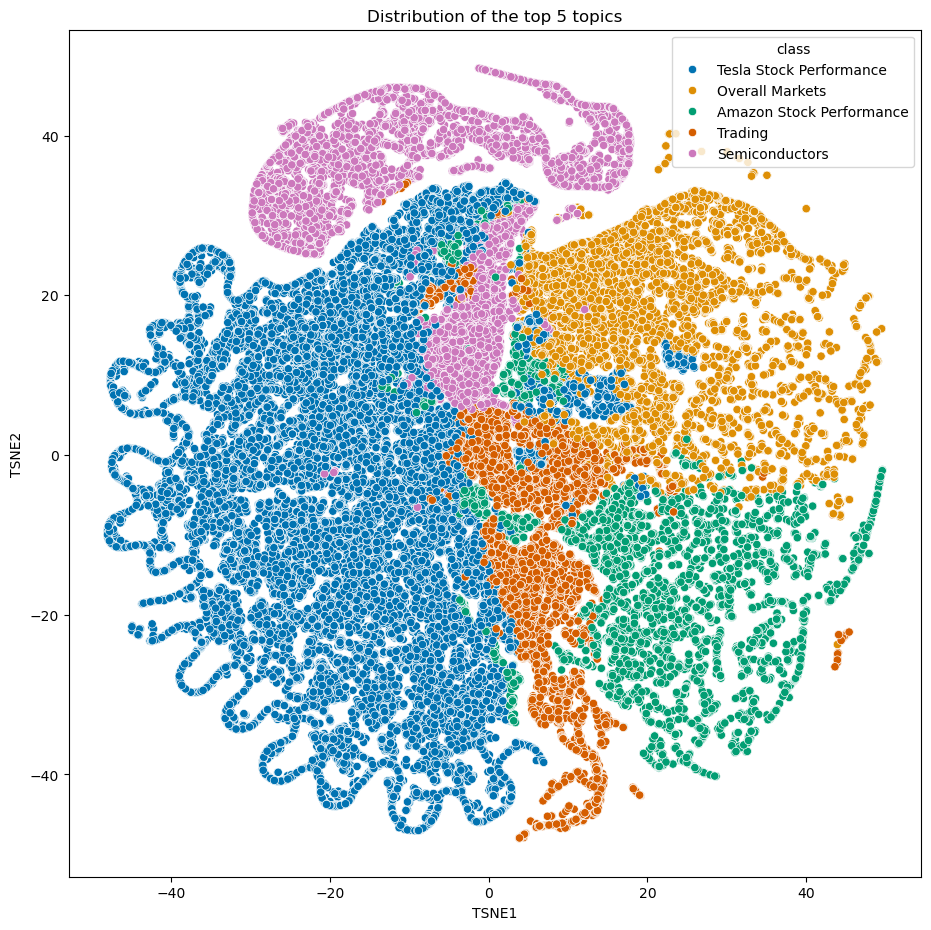

In [30]:
plt.figure(figsize=(11,11))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="class", data=tsne_transform, palette="colorblind")
plt.title("Distribution of the top 5 topics")
plt.show()

In [31]:
H_repres_norm = pd.DataFrame(H, columns=topic_name_dict.values(), index=df.index)
H_repres_norm = H_repres_norm.divide(H_repres_norm.sum(axis=1), axis=0)

In [32]:
H_repres_norm.head(10)

,Tesla Stock Performance,Overall Markets,Semiconductors,Trading,Amazon Stock Performance
0,0.494760,0.000000,0.125809,0.306974,0.072458
1,1.000000,0.000000,0.000000,0.000000,0.000000
2,0.778256,0.000000,0.035594,0.186150,0.000000
3,0.527704,0.000000,0.172676,0.247787,0.051833
4,0.431086,0.000000,0.426740,0.102153,0.040021
6,0.469220,0.000000,0.075800,0.170065,0.284914
7,0.257959,0.372920,0.000002,0.008542,0.360577
8,0.404579,0.294825,0.018638,0.281958,0.000000
9,0.548280,0.000000,0.172229,0.000000,0.279490
10,1.000000,0.000000,0.000000,0.000000,0.000000


Sample tweets from NMF:

In [33]:
join_df = df.join(H_repres_norm).dropna()
join_df

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm,Tesla Stock Performance,Overall Markets,Semiconductors,Trading,Amazon Stock Performance
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,Tesla,"Tesla, Inc.",Mainstream media has done an amazing job at br...,"[mainstream, media, done, amaz, job, brainwash...",0.494760,0.000000,0.125809,0.306974,0.072458
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...,"[tesla, deliveri, estim, around, analyst, tsla]",1.000000,0.000000,0.000000,0.000000,0.000000
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,Tesla,"Tesla, Inc.",3/ Even if I include 63.0M unvested RSUs as of...,"[even, includ, unvest, rsus, addit, equiti, ne...",0.778256,0.000000,0.035594,0.186150,0.000000
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,Tesla,"Tesla, Inc.",@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,"[hahaha, still, tri, stop, tesla, fsd, bro, ge...",0.527704,0.000000,0.172676,0.247787,0.051833
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",Tesla,"Tesla, Inc.","@RealDanODowd @Tesla Stop trying to kill kids,...","[stop, tri, kill, kid, sad, derang, old, man]",0.431086,0.000000,0.426740,0.102153,0.040021
...,...,...,...,...,...,...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,Xpeng,XPeng Inc.,Some of the fastest growing tech stocks on the...,"[fastest, grow, tech, stock, market, mix, upst...",0.175708,0.172642,0.000000,0.000000,0.651651
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",Xpeng,XPeng Inc.,"With earnings on the horizon, here is a quick ...","[earn, horizon, quick, snapshot, largest, incr...",0.241779,0.057441,0.000000,0.064778,0.636002
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,Xpeng,XPeng Inc.,Our record delivery results are a testimony of...,"[record, deliveri, result, testimoni, unwav, p...",0.818022,0.000000,0.032743,0.000000,0.149235
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",Xpeng,XPeng Inc.,"We delivered 10,412 Smart EVs in Sep 2021, rea...","[deliv, smart, ev, sep, reach, mileston, unit,...",0.359481,0.000000,0.013481,0.618714,0.008324


In [34]:
tslatop = join_df.sort_values(by=["Tesla Stock Performance", "Amazon Stock Performance"], ascending=[False, False])
tslatop.head(15)

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm,Tesla Stock Performance,Overall Markets,Semiconductors,Trading,Amazon Stock Performance
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,Tesla,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...,"[tesla, deliveri, estim, around, analyst, tsla]",1.0,0.0,0.0,0.0,0.0
10,2022-09-29 21:58:00+00:00,"Tomorrow, Tesla, $Tesla, AI day 2 is ongoing.\...",Tesla,"Tesla, Inc.","Tomorrow, Tesla, $Tesla, AI day 2 is ongoing.\...","[tomorrow, tesla, tesla, ai, day, ongo, unusu,...",1.0,0.0,0.0,0.0,0.0
18,2022-09-29 19:24:50+00:00,$Tesla Cybertruck can act as a boat according ...,Tesla,"Tesla, Inc.",$Tesla Cybertruck can act as a boat according ...,"[tesla, cybertruck, act, boat, accord, elon]",1.0,0.0,0.0,0.0,0.0
19,2022-09-29 19:17:48+00:00,#GigaBerlinBrandenburg\n@tesla destination cha...,Tesla,"Tesla, Inc.",#GigaBerlinBrandenburg\n@tesla destination cha...,"[destin, charger, readi, charg, electr, vehicl...",1.0,0.0,0.0,0.0,0.0
35,2022-09-29 17:41:43+00:00,Friendly reminder to the $Tesla holders: As th...,Tesla,"Tesla, Inc.",Friendly reminder to the $Tesla holders: As th...,"[friend, remind, tesla, holder, valu, tesla, g...",1.0,0.0,0.0,0.0,0.0
46,2022-09-29 16:43:49+00:00,How do EVs charge after a natural disaster? @t...,Tesla,"Tesla, Inc.",How do EVs charge after a natural disaster? @t...,"[ev, charg, natur, disast, sazq]",1.0,0.0,0.0,0.0,0.0
54,2022-09-29 15:35:28+00:00,"How are those Model S ""boats"" doing, Mr. Fraud...",Tesla,"Tesla, Inc.","How are those Model S ""boats"" doing, Mr. Fraud...","[model, boat, mr, tesla]",1.0,0.0,0.0,0.0,0.0
58,2022-09-29 14:59:50+00:00,This supports my comments yesterday that full-...,Tesla,"Tesla, Inc.",This supports my comments yesterday that full-...,"[support, comment, yesterday, fleet, sale, cou...",1.0,0.0,0.0,0.0,0.0
65,2022-09-29 14:21:24+00:00,"#FSDBeta avoids a cyclist, pedestrians and a c...",Tesla,"Tesla, Inc.","#FSDBeta avoids a cyclist, pedestrians and a c...","[avoid, cyclist, pedestrian, car, pull, span, ...",1.0,0.0,0.0,0.0,0.0
74,2022-09-29 12:19:44+00:00,$Tesla ends Hawaii’s dependency on coal https:...,Tesla,"Tesla, Inc.",$Tesla ends Hawaii’s dependency on coal https:...,"[tesla, end, hawaii, depend, coal]",1.0,0.0,0.0,0.0,0.0


In [35]:
tslatop["Tweet"].loc[81]

'This has the potential to become worse than VW’s Dieselgate, if @NHTSAgov does its job. \n\nIs $35bn a lot? \n\n$Tesla https://t.co/pPZ6cpzlOE'

In [36]:
amzntop = join_df[join_df["Stock Name"] == "Amazon"]
amzntop = join_df.sort_values(by=["Amazon Stock Performance", "Tesla Stock Performance"], ascending=[False, False])
amzntop.head(10)

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm,Tesla Stock Performance,Overall Markets,Semiconductors,Trading,Amazon Stock Performance
37428,2022-09-29 13:04:39+00:00,*AMAZON TO LOAN OVER $150M TO SMALL BUSINESSES...,Microsoft,Microsoft Corporation,*AMAZON TO LOAN OVER $150M TO SMALL BUSINESSES...,"[amazon, loan, small, busi, next, year, bloomb...",0.0,0.0,0.0,0.0,1.0
37432,2022-09-28 22:16:43+00:00,"*AMAZON RAISING HOURLY WAGES FOR WAREHOUSE, SH...",Microsoft,Microsoft Corporation,"*AMAZON RAISING HOURLY WAGES FOR WAREHOUSE, SH...","[amazon, rais, hour, wage, warehous, ship, wor...",0.0,0.0,0.0,0.0,1.0
37435,2022-09-28 18:32:24+00:00,"Amazon, $Amazon, unveils device that tracks ho...",Microsoft,Microsoft Corporation,"Amazon, $Amazon, unveils device that tracks ho...","[amazon, amazon, unveil, devic, track, breath,...",0.0,0.0,0.0,0.0,1.0
37436,2022-09-28 16:45:35+00:00,"Amazon, $Amazon, will link its Astro robot wit...",Microsoft,Microsoft Corporation,"Amazon, $Amazon, will link its Astro robot wit...","[amazon, amazon, link, astro, robot, ring, vir...",0.0,0.0,0.0,0.0,1.0
37437,2022-09-28 16:08:33+00:00,"Amazon, $Amazon, has announced the Kindle Scri...",Microsoft,Microsoft Corporation,"Amazon, $Amazon, has announced the Kindle Scri...","[amazon, amazon, announc, kindl, scribe, first...",0.0,0.0,0.0,0.0,1.0
37451,2022-09-26 05:50:43+00:00,"Amazon, $Amazon, to hold mid-October sale to c...",Microsoft,Microsoft Corporation,"Amazon, $Amazon, to hold mid-October sale to c...","[amazon, amazon, hold, sale, captur, holiday, ...",0.0,0.0,0.0,0.0,1.0
37463,2022-09-23 14:58:30+00:00,Jeff Bezos in his office $Amazon (1997) https:...,Microsoft,Microsoft Corporation,Jeff Bezos in his office $Amazon (1997) https:...,"[jeff, bezo, offic, amazon]",0.0,0.0,0.0,0.0,1.0
37483,2022-09-20 20:08:13+00:00,"Amazon's, $Amazon, cargo airline is growing at...",Microsoft,Microsoft Corporation,"Amazon's, $Amazon, cargo airline is growing at...","[amazon, cargo, airlin, grow, slowest, pace, s...",0.0,0.0,0.0,0.0,1.0
37501,2022-09-17 22:08:37+00:00,$Amazon generates 74% of operating profits fro...,Microsoft,Microsoft Corporation,$Amazon generates 74% of operating profits fro...,"[amazon, generat, oper, profit, aw]",0.0,0.0,0.0,0.0,1.0
37511,2022-09-16 16:33:10+00:00,"Jeff Bezos of Amazon, $Amazon, lost his spot a...",Microsoft,Microsoft Corporation,"Jeff Bezos of Amazon, $Amazon, lost his spot a...","[jeff, bezo, amazon, amazon, lost, spot, perso...",0.0,0.0,0.0,0.0,1.0


In [37]:
amzntop["Tweet"].loc[37511]

"Jeff Bezos of Amazon, $Amazon, lost his spot as the world's second-richest person to Indian billionaire Gautam Adani, per Bloomberg."